# Recommendation using implicit library

In [1]:
import pandas as pd
import seaborn as sns
from implicit.nearest_neighbours import CosineRecommender
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.preprocessing import normalize

sns.set()

In [2]:
# Load data
df = pd.read_csv("rating2.csv")
df.head()

,users,movies,ratings
0,Lisa Rose,Lady in the Water,2.5
1,Lisa Rose,Snakes on a Plane,3.5
2,Lisa Rose,Just My Luck,3.0
3,Lisa Rose,Superman Returns,3.5
4,Lisa Rose,"You, Me and Dupree",2.5


In [3]:
user_items = df.pivot(columns="movies", index="users", values="ratings")
user_items

movies,Just My Luck,Lady in the Water,Snakes on a Plane,Superman Returns,The Night Listener,"You, Me and Dupree"
users,,,,,,
Claudia Puig,3.0,NaN,3.5,4.0,4.5,2.5
Gene Seymour,1.5,3.0,3.5,5.0,3.0,3.5
Jack Matthews,NaN,3.0,4.0,5.0,3.0,3.5
Lisa Rose,3.0,2.5,3.5,3.5,3.0,2.5
Michael Phillips,NaN,2.5,3.0,3.5,4.0,NaN
Mick LaSalle,2.0,3.0,4.0,3.0,3.0,2.0
Toby,NaN,NaN,4.5,4.0,NaN,1.0


## Computing cosine similarity

### Using sklearn

In [4]:
# Fill NaN values with 0, because cosine similarity doesn't allow NaN values.
claudia = user_items.iloc[0].fillna(0).values
gene = user_items.iloc[1].fillna(0).values


cosine_similarity([claudia], [gene])

array([[0.8847892]])

In [5]:
df = pd.DataFrame(
    cosine_similarity(user_items.fillna(0)),
    index=user_items.index,
    columns=user_items.index,
)
df.head(n=10)

users,Claudia Puig,Gene Seymour,Jack Matthews,Lisa Rose,Michael Phillips,Mick LaSalle,Toby
users,,,,,,,
Claudia Puig,1.000000,0.884789,0.834622,0.928841,0.807057,0.885658,0.702841
Gene Seymour,0.884789,1.000000,0.982325,0.960646,0.862337,0.955691,0.770024
Jack Matthews,0.834622,0.982325,1.000000,0.906551,0.880155,0.928989,0.805550
Lisa Rose,0.928841,0.960646,0.906551,1.000000,0.838220,0.981831,0.712501
Michael Phillips,0.807057,0.862337,0.880155,0.838220,1.000000,0.891702,0.683164
Mick LaSalle,0.885658,0.955691,0.928989,0.981831,0.891702,1.000000,0.734179
Toby,0.702841,0.770024,0.805550,0.712501,0.683164,0.734179,1.000000


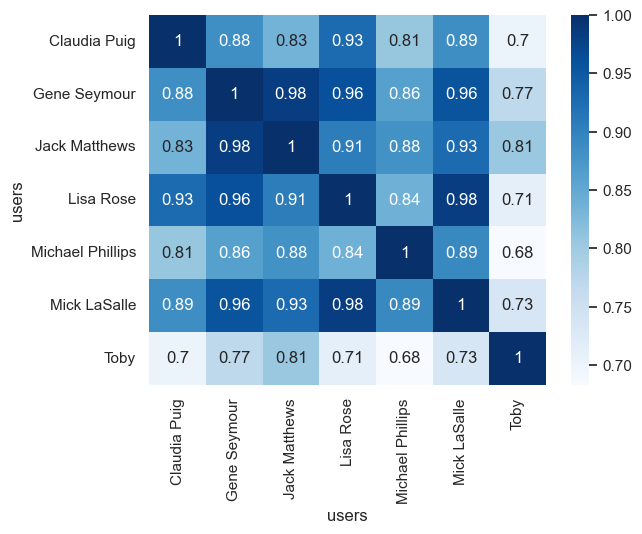

In [6]:
sns.heatmap(df, annot=True, cmap="Blues");

In [7]:
# Finding similar users
user = "Toby"
n = 5

users = df.loc[user].sort_values(ascending=False).drop(user).head(n)
users

users
Jack Matthews    0.805550
Gene Seymour     0.770024
Mick LaSalle     0.734179
Lisa Rose        0.712501
Claudia Puig     0.702841
Name: Toby, dtype: float64

In [8]:
# 1 - cosine_similarity
cosine_distances([claudia], [gene])

array([[0.1152108]])

In [9]:
1 - cosine_distances([claudia], [gene])

array([[0.8847892]])

### Using implicit

In [10]:
df = pd.read_csv("rating2.csv")
df["users"] = df["users"].astype("category")
df["movies"] = df["movies"].astype("category")

users = df.users.cat.categories
movies = df.movies.cat.categories

user_ids = df.users.cat.codes
movie_ids = df.movies.cat.codes

ratings = df.ratings.astype(float)

df.head()

,users,movies,ratings
0,Lisa Rose,Lady in the Water,2.5
1,Lisa Rose,Snakes on a Plane,3.5
2,Lisa Rose,Just My Luck,3.0
3,Lisa Rose,Superman Returns,3.5
4,Lisa Rose,"You, Me and Dupree",2.5


In [11]:
import numpy as np

(list(zip(np.unique(movie_ids), movies[np.unique(movie_ids)])))

[(np.int8(0), 'Just My Luck'),
 (np.int8(1), 'Lady in the Water'),
 (np.int8(2), 'Snakes on a Plane'),
 (np.int8(3), 'Superman Returns'),
 (np.int8(4), 'The Night Listener'),
 (np.int8(5), 'You, Me and Dupree')]

In [12]:
(list(zip(np.unique(user_ids), users[np.unique(user_ids)])))

[(np.int8(0), 'Claudia Puig'),
 (np.int8(1), 'Gene Seymour'),
 (np.int8(2), 'Jack Matthews'),
 (np.int8(3), 'Lisa Rose'),
 (np.int8(4), 'Michael Phillips'),
 (np.int8(5), 'Mick LaSalle'),
 (np.int8(6), 'Toby')]

In [13]:
user_items = coo_matrix((ratings, (user_ids, movie_ids))).tocsr()
user_items

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 35 stored elements and shape (7, 6)>

In [14]:
# This computes similarities for each items.
model = CosineRecommender()
model.fit(user_items)

/Users/alextanhongpin/Documents/go/recommender-learn/.venv/lib/python3.12/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 6.818771362304688e-05 seconds
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
superman = 3

ids, scores = model.similar_items(superman, N=5)
pd.DataFrame(
    {
        "movies": movies[ids],
        "scores": scores,
    }
)

,movies,scores
0,Superman Returns,1.000000
1,Snakes on a Plane,0.979878
2,"You, Me and Dupree",0.915302
3,The Night Listener,0.892170
4,Lady in the Water,0.836486


In [16]:
# This computes similarities for each users.
model = CosineRecommender()
model.fit(user_items.T)

/Users/alextanhongpin/Documents/go/recommender-learn/.venv/lib/python3.12/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 2.7179718017578125e-05 seconds
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
toby = 6

ids, scores = model.similar_items(toby, N=5, filter_items=[toby])
pd.DataFrame(
    {
        "users": users[ids],
        "scores": scores,
    }
)

,users,scores
0,Jack Matthews,0.805550
1,Gene Seymour,0.770024
2,Mick LaSalle,0.734179
3,Lisa Rose,0.712501
4,Claudia Puig,0.702841


### Finding item-item similarities

In [18]:
toby = 6
ids, scores = model.recommend(
    toby, user_items[toby], N=10, filter_already_liked_items=True
)
ids, scores

(array([1, 0, 4, 6, 5, 3, 2], dtype=int32),
 array([9.21873948, 8.35682168, 8.20527681, 7.20915624, 0.        ,
        0.        , 0.        ]))

## Alternative Least Squares

In [19]:
from implicit.cpu.als import AlternatingLeastSquares

model = AlternatingLeastSquares()
model.fit(user_items)

  0%|          | 0/15 [00:00<?, ?it/s]

In [20]:
toby = 6

# recommend items for user.
ids, scores = model.recommend(toby, user_items[toby], N=5)
pd.DataFrame({"movies": movies[ids], "scores": scores}, index=ids)

,movies,scores
4,The Night Listener,5.242415e-05
0,Just My Luck,-3.326312e-03
1,Lady in the Water,-4.432209e-03
3,Superman Returns,-3.402823e+38
2,Snakes on a Plane,-3.402823e+38


In [21]:
superman = 3

# find related items.
ids, scores = model.similar_items(superman, N=5, filter_items=[superman])
pd.DataFrame({"movies": movies[ids], "scores": scores}, index=ids)

,movies,scores
2,Snakes on a Plane,0.987136
5,"You, Me and Dupree",0.192650
4,The Night Listener,0.065915
1,Lady in the Water,0.047937
0,Just My Luck,-0.007842


In [22]:
# find related users.
toby = 6

ids, scores = model.similar_users(toby, N=5, filter_users=[toby])
pd.DataFrame({"users": users[ids], "scores": scores}, index=ids)

,users,scores
2,Jack Matthews,0.786501
0,Claudia Puig,0.760317
1,Gene Seymour,0.754375
5,Mick LaSalle,0.752308
3,Lisa Rose,0.751921
